## Section 1: Preprocessing

In this section, we will preprocess our dataset which consists of two main steps. In the first step, we will revise some features such as dates by splitting into seperate columns (Month, Day, Year) and turning string values for time (ex. 1 yr 1 mon) to a numerical values, representing months (i.e. 13). Then, we will look standardize our numerical features. 

Note: We will not create dummy variables for this model as that can create thousands of more variables for categorial features with many levels.

In [1]:
# Import necessary packages.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Read in the dataset and see its info()

VL_df = pd.read_csv(f'./data/Vehicle_Loan_DataWrang.csv')
VL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      233154 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

There are features whose data type is object. We will first convert 'Date.of.Birth' and 'DisbursalDate' whose values are formatted the same. We will extract the year, month and day for each of these values.

In [3]:
# Turn these date features into datetime objects.
VL_df['Date.of.Birth'] = VL_df['Date.of.Birth'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
VL_df['DisbursalDate'] = VL_df['DisbursalDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

# Create separate year, month and day features for the feature 'Date.of.Birth'
VL_df['birth_year'] = VL_df['Date.of.Birth'].dt.year
VL_df['birth_month'] = VL_df['Date.of.Birth'].dt.month
VL_df['birth_day'] = VL_df['Date.of.Birth'].dt.day

# Create separate year, month and day features for the feature 'DisbursalDate'
VL_df['Disbursal_year'] = VL_df['DisbursalDate'].dt.year
VL_df['Disbursal_month'] = VL_df['DisbursalDate'].dt.month
VL_df['Disbursal_day'] = VL_df['DisbursalDate'].dt.day

# Take a look at the dateframe to see that the date components were extracted correctly.
VL_df[['Date.of.Birth', 'birth_year','birth_month', 'birth_day', 
       'DisbursalDate', 'Disbursal_year','Disbursal_month', 'Disbursal_day']]

,Date.of.Birth,birth_year,birth_month,birth_day,DisbursalDate,Disbursal_year,Disbursal_month,Disbursal_day
0,1984-01-01,1984,1,1,2018-08-03,2018,8,3
1,1985-07-31,1985,7,31,2018-09-26,2018,9,26
2,1985-08-24,1985,8,24,2018-08-01,2018,8,1
3,1993-12-30,1993,12,30,2018-10-26,2018,10,26
4,1977-12-09,1977,12,9,2018-09-26,2018,9,26
...,...,...,...,...,...,...,...,...
233149,1988-08-01,1988,8,1,2018-10-26,2018,10,26
233150,1988-12-05,1988,12,5,2018-10-23,2018,10,23
233151,1976-06-01,1976,6,1,2018-10-24,2018,10,24
233152,1994-03-26,1994,3,26,2018-09-29,2018,9,29


In [4]:
# features. Those new features will be much more useful for the model.

VL_df = VL_df.drop(['Date.of.Birth', 'DisbursalDate'], axis=1)
VL_df.info()    # Output to see that those two features are gone and replaced with new ones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Employment.Type                      233154 non-null  object 
 9   State_ID                             233154 non-null  int64  
 10  Employee_code_ID                     233154 non-null  int64  
 11  MobileNo_Avl_

Now, we convert the 'AVG.ACCT.AGE' and 'CRT.HISTORY.LENGTH' features whose values represent time in the format (i.e. '1yrs 11mon'). We will convert them to numerical values of months.

In [5]:
# The first two lines remove the 'yrs' and 'mon' portion of the strings and save them 
# in a new dataframe column VL_df['AVG.ACCT.AGE']. The last line will turn it into the age
# in numerical months.
VL_df['AVG.ACCT.AGE'] = VL_df['AVERAGE.ACCT.AGE'].apply(lambda x: x.replace('mon',''))
VL_df['AVG.ACCT.AGE'] = VL_df['AVG.ACCT.AGE'].apply(lambda x: x.replace('yrs',''))
VL_df['AVG.ACCT.AGE'] = VL_df['AVG.ACCT.AGE'].apply(lambda x: 12*int(x[:x.find(' ')+1]) + int(x[x.find(' '):]))

# Similar as above but for credit history length.
VL_df['CRT.HISTORY.LENGTH'] = VL_df['CREDIT.HISTORY.LENGTH'].apply(lambda x: x.replace('mon',''))
VL_df['CRT.HISTORY.LENGTH'] = VL_df['CRT.HISTORY.LENGTH'].apply(lambda x: x.replace('yrs',''))
VL_df['CRT.HISTORY.LENGTH'] = VL_df['CRT.HISTORY.LENGTH'].apply(lambda x: 12*int(x[:x.find(' ')+1]) + int(x[x.find(' '):]))

# Verify that the new feature values were computed correctly.
VL_df[['AVERAGE.ACCT.AGE', 'AVG.ACCT.AGE','CREDIT.HISTORY.LENGTH','CRT.HISTORY.LENGTH']]

,AVERAGE.ACCT.AGE,AVG.ACCT.AGE,CREDIT.HISTORY.LENGTH,CRT.HISTORY.LENGTH
0,0yrs 0mon,0,0yrs 0mon,0
1,1yrs 11mon,23,1yrs 11mon,23
2,0yrs 0mon,0,0yrs 0mon,0
3,0yrs 8mon,8,1yrs 3mon,15
4,0yrs 0mon,0,0yrs 0mon,0
...,...,...,...,...
233149,1yrs 9mon,21,3yrs 3mon,39
233150,0yrs 6mon,6,0yrs 6mon,6
233151,0yrs 0mon,0,0yrs 0mon,0
233152,0yrs 0mon,0,0yrs 0mon,0


In [6]:
# Drop the original columns.
VL_df = VL_df.drop(['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], axis=1)
VL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Employment.Type                      233154 non-null  object 
 9   State_ID                             233154 non-null  int64  
 10  Employee_code_ID                     233154 non-null  int64  
 11  MobileNo_Avl_

In [7]:
## We update our categorial columns list from the Exploratory Analysis section with 
## our new features.
categorical_cols = ['UniqueID', 'branch_id', 'supplier_id', 'manufacturer_id', 
                   'Current_pincode_ID', 'Employment.Type',
                   'State_ID', 'Employee_code_ID', 
                   'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 
                   'Driving_flag', 'Passport_flag',
                   'birth_year','birth_month','birth_day', 'Disbursal_year',
                   'Disbursal_month','Disbursal_day','AVG.ACCT.AGE', 'CRT.HISTORY.LENGTH']

In [8]:
# Check the features out to see all numerical
VL_df[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   UniqueID            233154 non-null  int64 
 1   branch_id           233154 non-null  int64 
 2   supplier_id         233154 non-null  int64 
 3   manufacturer_id     233154 non-null  int64 
 4   Current_pincode_ID  233154 non-null  int64 
 5   Employment.Type     233154 non-null  object
 6   State_ID            233154 non-null  int64 
 7   Employee_code_ID    233154 non-null  int64 
 8   MobileNo_Avl_Flag   233154 non-null  int64 
 9   Aadhar_flag         233154 non-null  int64 
 10  PAN_flag            233154 non-null  int64 
 11  VoterID_flag        233154 non-null  int64 
 12  Driving_flag        233154 non-null  int64 
 13  Passport_flag       233154 non-null  int64 
 14  birth_year          233154 non-null  int64 
 15  birth_month         233154 non-null  int64 
 16  bi

In [9]:
# Create numerical values for Employee.Type
replace_map = {'Employment.Type': {'Other': 1, 'Salaried': 2,'Self employed': 3}}
VL_df = VL_df.replace(replace_map)

In [10]:
replace_map = {'PERFORM_CNS.SCORE.DESCRIPTION':{'Not Scored: More than 50 active Accounts found' : 0, 
                                               'Not Scored: Only a Guarantor':0,
                                               'Not Scored: No Updates available in last 36 months':0,
                                               'Not Scored: No Activity seen on the customer (Inactive)':0,
                                               'Not Scored: Not Enough Info available on the customer':0,
                                               'Not Scored: Sufficient History Not Available':0,
                                               'No Bureau History Available':0, 'C-Very Low Risk':1,
                                               'A-Very Low Risk':1, 'D-Very Low Risk':1, 'B-Very Low Risk':1,
                                               'M-Very High Risk':1, 'F-Low Risk':2, 'E-Low Risk':2, 
                                               'G-Low Risk':2, 'H-Medium Risk':3, 'I-Medium Risk':3,
                                               'K-High Risk':4, 'J-High Risk':4, 'M-Very High Risk':5,
                                               'L-Very High Risk':5}}

VL_df = VL_df.replace(replace_map)
VL_df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

0    129785
1     50728
2     18294
3     12412
4     12025
5      9910
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

In [11]:
VL_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Employment.Type                      233154 non-null  int64  
 9   State_ID                             233154 non-null  int64  
 10  Employee_code_ID                     233154 non-null  int64  
 11  MobileNo_Avl_

## Standardization

In [12]:
# Splitting the training and testing data

# Separate into features and predictor, X and y. 'UniqueID', 'Current_pincode_ID', 'supplier_id'
# were all not useful features based on their description so leave out of model.
X = VL_df.drop(['loan_default', 'UniqueID', 'Current_pincode_ID', 'supplier_id'], axis=1)
y = VL_df['loan_default']   # this is our predictor variable

# Since there is an imbalance in the two classes (0 and 1) we will use SMOTE to resample
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_sample(X, y.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=26)

In [13]:
# Data standardization: X_train_stand, X_test_stand
X_train_stand = X_train.copy() 
X_test_stand = X_test.copy()

for i in X_train.columns:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [14]:
# Create a list of all numerical features: num_cols

num_cols = ['ltv','disbursed_amount', 'asset_cost', 'PERFORM_CNS.SCORE', 
                'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 
                'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 
                'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 
                'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 
                'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
                'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES']

/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Log Transform Boxplots After Standardization')

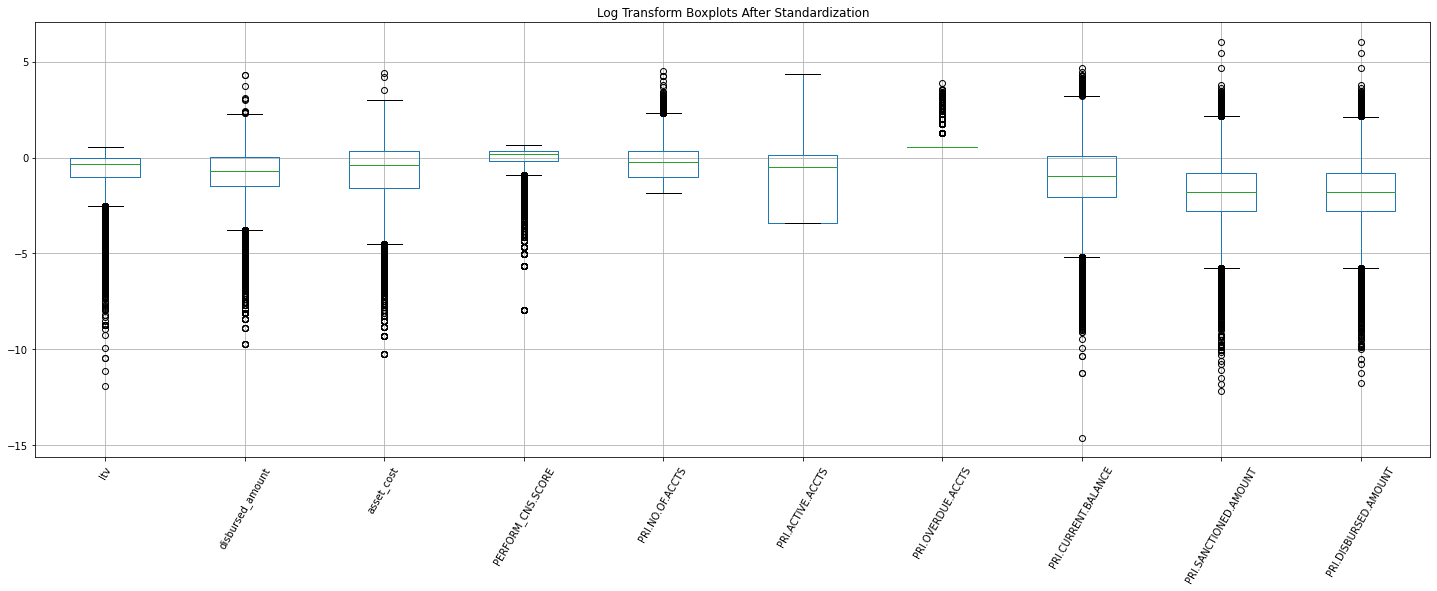

In [15]:
# Plot boxplots for new standardized numerical features. Part 1

plt.figure(figsize = (25,8))
ax = np.log(X_train_stand[num_cols[0:10]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots After Standardization')

/Users/student/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Log Transform Boxplots After Standardization')

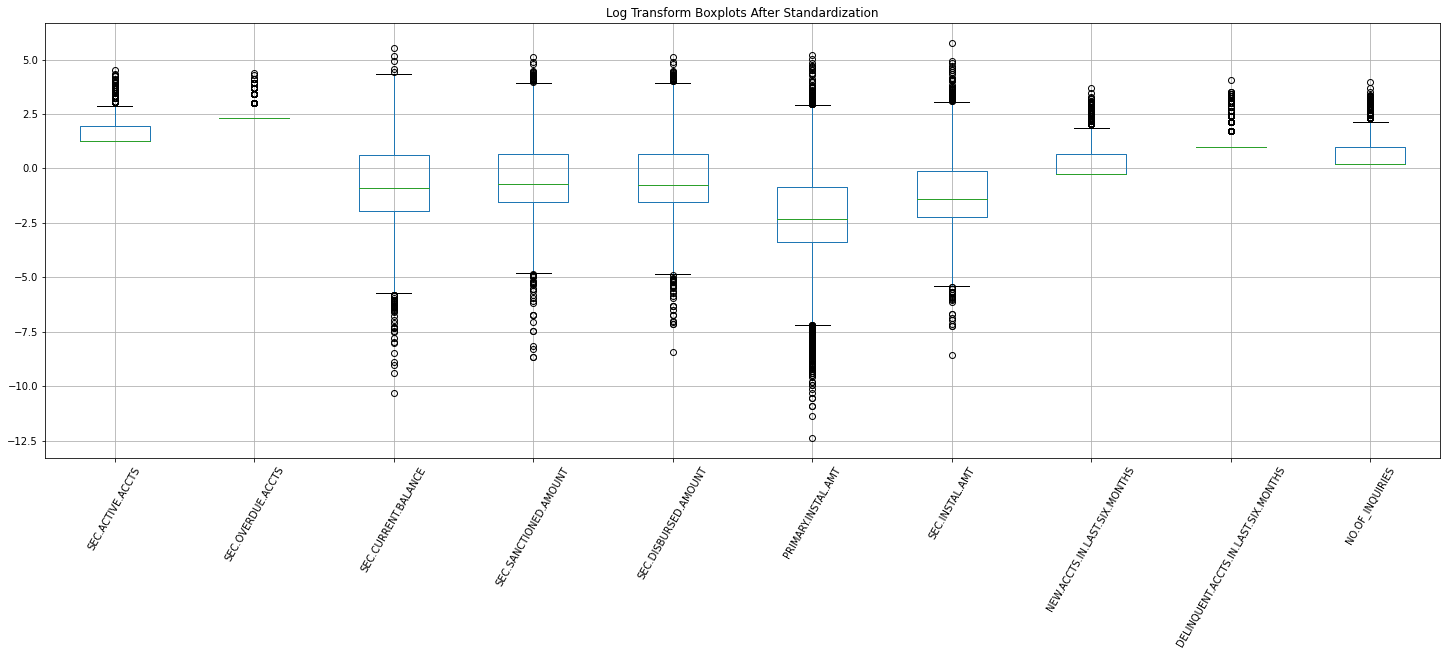

In [16]:
# Plot boxplots for new standardized numerical features. Part 2

plt.figure(figsize = (25,8))
ax = np.log(X_train_stand[num_cols[11:22]]).boxplot()
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.set_title('Log Transform Boxplots After Standardization')

## Section 2: Modeling

Now that we have preprocessed our data, we go on to modeling. Due to our large dataset, I decided to different decision tree models for our modeling, which were quicker in computation time than other classification models like nearest neighbor and logistic regression. 

We will perform grid search cross validation for all three models and try to obtain the highest f1-score without overfitting. My goal is to achieve at least a 0.75 f1-score and achieve above 70% recall score for our default value of 1. We also want to limit the number of n_estimators due to the long computation time required.

In [17]:
# Import modeling packages

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
import sklearn.metrics

## Model 1: Decision Tree, Gini vs Entropy

We will first use a decision tree to predict our feature, 'loan_default' value of 0 or 1. We will compare the 'gini' and 'entropy' models and model various max_depth parameters.

In [18]:
from sklearn import tree, metrics

# Build intitial decision tree model. We will use Grid Search CV after.
decision_tree = tree.DecisionTreeClassifier(random_state=1234)
param_dict = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(5,26)
}

# Perform GridSearchCV
grid_0 = GridSearchCV(decision_tree, param_grid=param_dict, cv=5,verbose=1,n_jobs=-1)
grid_0.fit(X_train_stand, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 26)},
             verbose=1)

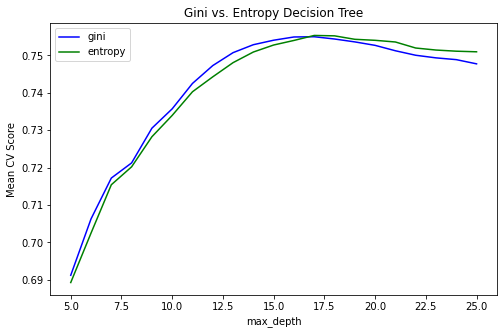

In [19]:
# Plot the line plots of cv scores for various max_depths 

max_depth_list = [n for n in range(5,26)]
cv_avg_gini = grid_0.cv_results_['mean_test_score'][0:21]
cv_avg_ent = grid_0.cv_results_['mean_test_score'][21:42]
plt.figure(figsize = (8,5))
plt.plot(max_depth_list, cv_avg_gini, color = 'b', label= 'gini')
plt.plot(max_depth_list, cv_avg_ent, color = 'g', label='entropy')
plt.xlabel('max_depth')
plt.ylabel('Mean CV Score')
plt.title('Gini vs. Entropy Decision Tree')
plt.legend(loc=0, borderaxespad=0.)
plt.savefig('Model1_Mean_CV.png')
plt.legend()
plt.show()

In [20]:
# Print out the best parameters and mean_cv score from the grid search.

print('The best parameters are ',grid_0.best_params_)
print('The respective estimator is ', grid_0.best_estimator_)
print('The corresponding best score is ', grid_0.best_score_)

The best parameters are  {'criterion': 'entropy', 'max_depth': 17}
The respective estimator is  DecisionTreeClassifier(criterion='entropy', max_depth=17, random_state=1234)
The corresponding best score is  0.7553480666210838


We see that the best params are the criterion of gini and max_depth of 16. We want to verfiy that this is not overplotting. Let's plot the training vs test CV scores for various max_depths for our Decision Tree Classifier. 

In [21]:
# Initialize train_scores and test_scores list where we will append the scores
train_scores = []
test_scores = []

# Build a decision tree model for various max_depths and obtain train and test scores
for max_depth in range(5,26):  
    dt = tree.DecisionTreeClassifier(random_state=1234, max_depth = max_depth)
    dt.fit(X_train_stand, y_train)
    train_scores.append(dt.score(X_train_stand, y_train))
    test_scores.append(dt.score(X_test_stand, y_test))

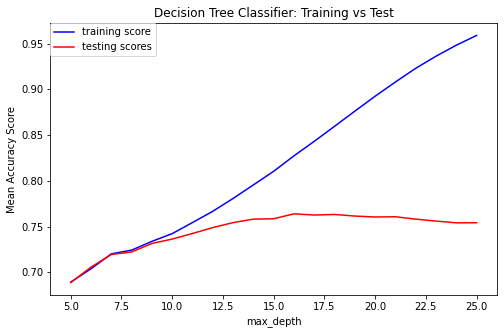

In [22]:
# Display line plots for the training and testing scores for max_depths
plt.figure(figsize = (8,5))
plt.plot(range(5,26), train_scores, color = 'b', label= 'training score')
plt.plot(range(5,26), test_scores, color = 'r', label='testing scores')
plt.xlabel('max_depth')
plt.ylabel('Mean Accuracy Score')
plt.title('Decision Tree Classifier: Training vs Test')
plt.legend(loc=0, borderaxespad=0.)
plt.savefig('Model1_TrainVsTest.png')

Since 16 is overplotting, we will go with the value 10. The overplotting is very small with max_depth of 10 and we obtain a test score close to 0.75. 

In [23]:
# Build model with best parameter values criterion='entropy' and max_depth=10
model_1 = tree.DecisionTreeClassifier(random_state=1234, max_depth = 10)
model_1.fit(X_train_stand, y_train)
y_pred = model_1.predict(X_test_stand)

# Obtain the accuracy score, f1 score and confusion matrix: ac, f1, cm
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# print results
print('Decision Tree: Accuracy=%.3f' % (ac))
print('Decision Tree: f1-score=%.3f' % (f1))
print(sklearn.metrics.classification_report(y_test, y_pred))

Decision Tree: Accuracy=0.736
Decision Tree: f1-score=0.729
              precision    recall  f1-score   support

           0       0.68      0.90      0.77     36561
           1       0.86      0.57      0.68     36457

    accuracy                           0.74     73018
   macro avg       0.77      0.74      0.73     73018
weighted avg       0.77      0.74      0.73     73018



While the accuaracy is alright, we want to see if we can do better. Let's use ensemble methods random forest and gradient boosting. But first, let's also see which features are most important in our model. 

30


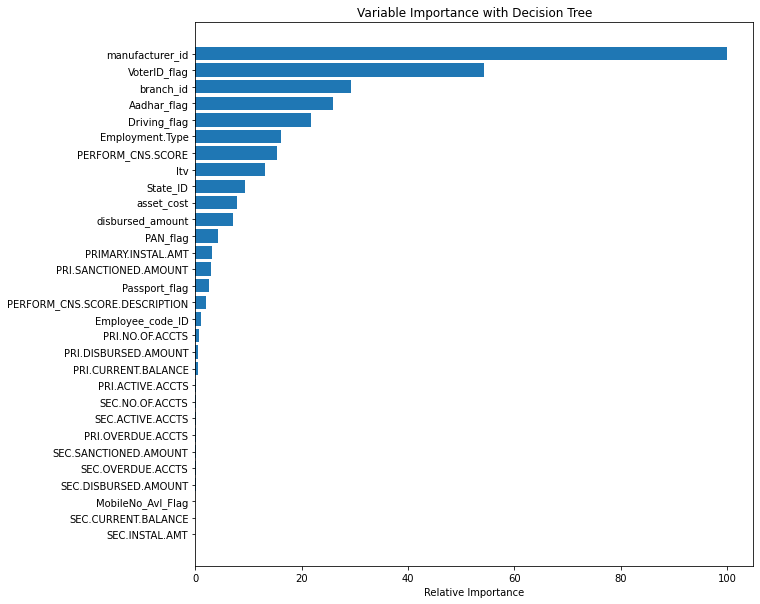

In [24]:
feature_importance = model_1.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance with Decision Tree')
plt.show()

## Model 2: Random Forest

In [25]:
# Gridsearch CV for Random Forest Classifier Ensemble model

from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap':[True],
    'max_depth':[5,10,15,20],  
    'n_estimators':[35,50,100,150]  
}

rf = RandomForestClassifier(random_state=1234)

grid_1 = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs=-1,verbose=2)
grid_1.fit(X_train_stand, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 15, 20],
                         'n_estimators': [35, 50, 100, 150]},
             verbose=2)

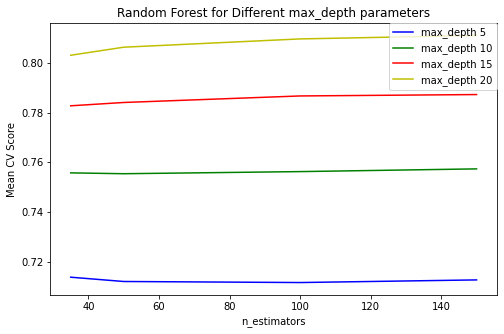

In [26]:
# Plot the line plots of cv scores for various max_depths. PLOT next to mean_train_score

n_est_list = [n for n in [35,50,100,150]]
cv_avg_MD5 = grid_1.cv_results_['mean_test_score'][0:4]
cv_avg_MD10 = grid_1.cv_results_['mean_test_score'][4:8]
cv_avg_MD15 = grid_1.cv_results_['mean_test_score'][8:12]
cv_avg_MD20 = grid_1.cv_results_['mean_test_score'][12:16]

plt.figure(figsize = (8,5))
plt.plot(n_est_list, cv_avg_MD5, color = 'b', label= 'max_depth 5')
plt.plot(n_est_list, cv_avg_MD10, color = 'g', label='max_depth 10')
plt.plot(n_est_list, cv_avg_MD15, color = 'r', label= 'max_depth 15')
plt.plot(n_est_list, cv_avg_MD20, color = 'y', label='max_depth 20')

plt.xlabel('n_estimators')
plt.ylabel('Mean CV Score')
plt.title('Random Forest for Different max_depth parameters')
plt.legend(loc=0, borderaxespad=0.)
plt.savefig('Model2_Mean_CV.png')
plt.show()

In [27]:
print('The respective estimator is ', grid_1.best_estimator_)
print('The best score is ', grid_1.best_score_)

The respective estimator is  RandomForestClassifier(max_depth=20, n_estimators=150, random_state=1234)
The best score is  0.8110063346806162


Based on our max_depth list, our cv score gets better with higher max_depth values. We want to make sure we don't overfit so we will plot the training and testing scores for random forest models of various max_depths.

In [28]:
# Initialize train_scores and test_scores list where we will append the scores
train_scores = []
test_scores = []

# Build a random forest model for various max_depths 
for max_depth in [5,10,15,20,30,50,100]:  
    rf = RandomForestClassifier(random_state=1234, max_depth = max_depth)
    rf.fit(X_train_stand, y_train)
    train_scores.append(rf.score(X_train_stand, y_train))
    test_scores.append(rf.score(X_test_stand, y_test))

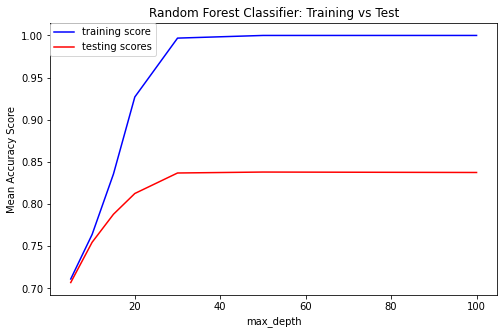

In [29]:
# Display line plots for the training and testing scores for max_depths
plt.figure(figsize = (8,5))
plt.plot([5,10,15,20,30,50,100], train_scores, color = 'b', label= 'training score')
plt.plot([5,10,15,20,30,50,100], test_scores, color = 'r', label='testing scores')
plt.xlabel('max_depth')
plt.ylabel('Mean Accuracy Score')
plt.title('Random Forest Classifier: Training vs Test')
plt.legend(loc=0, borderaxespad=0.)
plt.savefig('Model2_TrainVsTest.png')

Based on the chart, it looks like the training and test scores are pretty similar at a max_depth value of 10. While one might be tempted to choose 30 where the test score plateaus, it would be overfitting and hence not generalizable to new datasets. We will therefore use the max_depth value of 10 and n_estimators of 150 as accuracy score does not seem to be affected significantly by the number of trees.

In [30]:
model_2 = RandomForestClassifier(random_state=1234, n_estimators = 150, max_depth=10)
model_2.fit(X_train_stand, y_train)
y_pred = model_2.predict(X_test_stand)

# Obtain the accuracy score, f1 score and confusion matrix: ac, f1, cm
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# print results
print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print(sklearn.metrics.classification_report(y_test, y_pred))

Random Forest: Accuracy=0.755
Random Forest: f1-score=0.754
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     36561
           1       0.79      0.69      0.74     36457

    accuracy                           0.76     73018
   macro avg       0.76      0.76      0.75     73018
weighted avg       0.76      0.76      0.75     73018



30


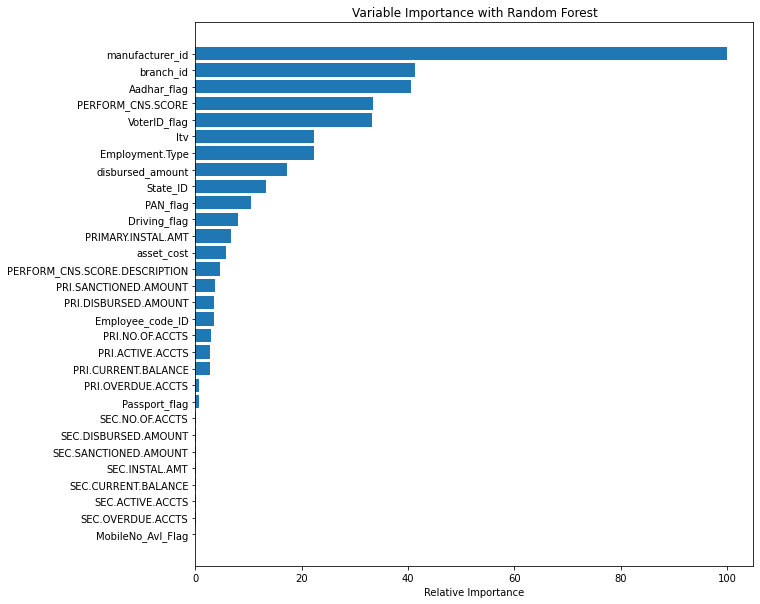

In [31]:
# print out importance of each feature

feature_importance = model_2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance with Random Forest')
plt.show()

## Model 3: Gradient Boosting Decision Tree

In [32]:
# Grid Search CV for Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'learning_rate':[0.1, 0.25, 0.5, 0.75, 1],
    'n_estimators': [20, 35, 50, 75]
}

gb = GradientBoostingClassifier(random_state=1234)

grid_2 = GridSearchCV(estimator = gb, param_grid = param_grid, cv = 5, n_jobs=-1,verbose=2)
grid_2.fit(X_train_stand, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.25, 0.5, 0.75, 1],
                         'n_estimators': [20, 35, 50, 75]},
             verbose=2)

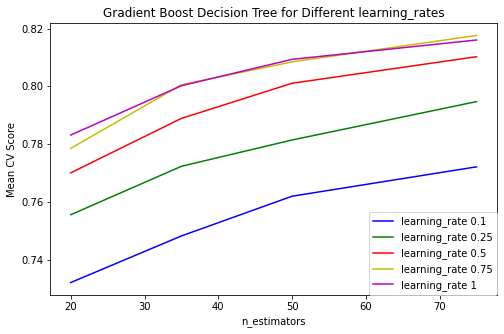

In [33]:
# Plot the line plots of cv scores for various max_depths 

n_est = [n for n in [20,35,50,75]]
cv_avg_LR01 = grid_2.cv_results_['mean_test_score'][0:4]
cv_avg_LR025 = grid_2.cv_results_['mean_test_score'][4:8]
cv_avg_LR05 = grid_2.cv_results_['mean_test_score'][8:12]
cv_avg_LR075 = grid_2.cv_results_['mean_test_score'][12:16]
cv_avg_LR1 = grid_2.cv_results_['mean_test_score'][16:20]

plt.figure(figsize = (8,5))
plt.plot(n_est, cv_avg_LR01, color = 'b', label= 'learning_rate 0.1')
plt.plot(n_est, cv_avg_LR025, color = 'g', label='learning_rate 0.25')
plt.plot(n_est, cv_avg_LR05, color = 'r', label= 'learning_rate 0.5')
plt.plot(n_est, cv_avg_LR075, color = 'y', label='learning_rate 0.75')
plt.plot(n_est, cv_avg_LR1, color = 'm', label='learning_rate 1')

plt.xlabel('n_estimators')
plt.ylabel('Mean CV Score')
plt.title('Gradient Boost Decision Tree for Different learning_rates')
plt.legend(loc=0, borderaxespad=0.)
plt.savefig('Model3_Mean_CV.png')
plt.show()

In [34]:
print('The best parameters are ',grid_2.best_params_)
print('The respective estimator is ', grid_2.best_estimator_)
print('The best score is ', grid_2.best_score_)

The best parameters are  {'learning_rate': 0.75, 'n_estimators': 75}
The respective estimator is  GradientBoostingClassifier(learning_rate=0.75, n_estimators=75,
                           random_state=1234)
The best score is  0.8176383432193637


The results are good. However, we want to tune the learning rate since a learning rate of 1 can lead to a quick convergence to a suboptimal CV score. Let's plot the train vs test scores for this hyperparameter.

In [35]:
# Initialize train_scores and test_scores list where we will append the scores
train_scores = []
test_scores = []

# Build a random forest model for various max_depths 
for learn_rate in [0.1, 0.25, 0.5, 0.75, 1]:  
    gb = GradientBoostingClassifier(random_state=1234, learning_rate = learn_rate)
    gb.fit(X_train_stand, y_train)
    train_scores.append(gb.score(X_train_stand, y_train))
    test_scores.append(gb.score(X_test_stand, y_test))

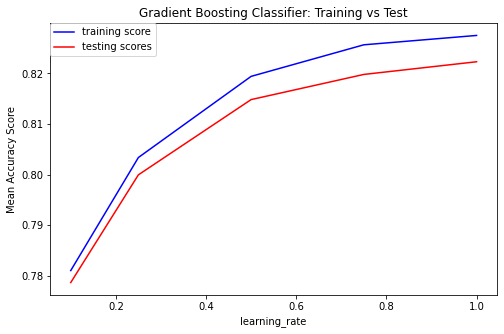

In [36]:
# Display line plots for the training and testing scores for max_depths
plt.figure(figsize = (8,5))
plt.plot([0.1, 0.25, 0.5, 0.75, 1], train_scores, color = 'b', label= 'training score')
plt.plot([0.1, 0.25, 0.5, 0.75, 1], test_scores, color = 'r', label='testing scores')
plt.xlabel('learning_rate')
plt.ylabel('Mean Accuracy Score')
plt.title('Gradient Boosting Classifier: Training vs Test')
plt.legend(loc=0, borderaxespad=0.)
plt.savefig('Model3_TrainVsTest.png')

Based off of this plot, it looks as if the test score for a learning rate of 0.25 is still pretty close to the training score and the overplotting isn't too significant. We will use 0.25 as the learning rate value for the final gradient boosting model.

In [37]:
# Build model with best parameter values n_estimators=150 and learning_rate=0.25

model_3 = GradientBoostingClassifier(random_state=1234, learning_rate = 0.25, n_estimators=150)
model_3.fit(X_train_stand, y_train)
y_pred = model_3.predict(X_test_stand)

# Obtain the accuracy score, f1 score and confusion matrix: ac, f1, cm
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# print results
print('Gradient Boost: Accuracy=%.3f' % (ac))
print('Gradient Boost: f1-score=%.3f' % (f1))
print(sklearn.metrics.classification_report(y_test, y_pred))

Gradient Boost: Accuracy=0.811
Gradient Boost: f1-score=0.809
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     36561
           1       0.90      0.70      0.79     36457

    accuracy                           0.81     73018
   macro avg       0.83      0.81      0.81     73018
weighted avg       0.83      0.81      0.81     73018



It looks like this model gives the best results with an f-1 score of 0.809. We conclude that this is the best model for our prediction.

30


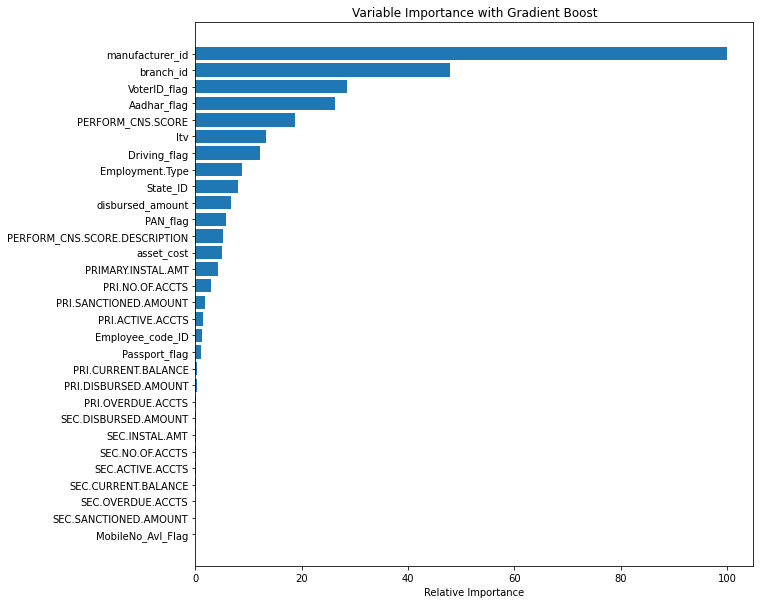

In [38]:
# print out importance of each feature

feature_importance = model_3.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance with Gradient Boost')
plt.savefig('FinalModel_VariableImportance.png')
plt.show()

### Bar plots for important features 

In [39]:
# Separate original dataset defaulters and non-defaulters
defaulter = VL_df[VL_df['loan_default']==1]
nondefaulter = VL_df[VL_df['loan_default']==0]

Let's create a barplot for the top five manufacturer IDs for defaulter and nondefaulters. 

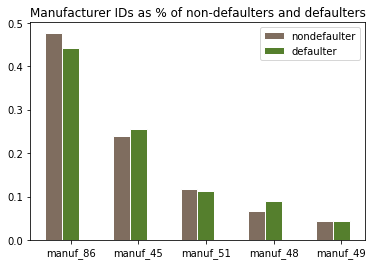

In [54]:
# Obtain percentage of top five manufacturer IDs.
def_manufact_86 = defaulter[defaulter['manufacturer_id']==86]['manufacturer_id'].count() / len(defaulter)
nondef_manufact_86 = nondefaulter[nondefaulter['manufacturer_id']==86]['manufacturer_id'].count() / len(nondefaulter)

def_manufact_45 = defaulter[defaulter['manufacturer_id']==45]['manufacturer_id'].count() / len(defaulter)
nondef_manufact_45 = nondefaulter[nondefaulter['manufacturer_id']==45]['manufacturer_id'].count() / len(nondefaulter)

def_manufact_51 = defaulter[defaulter['manufacturer_id']==51]['manufacturer_id'].count() / len(defaulter)
nondef_manufact_51 = nondefaulter[nondefaulter['manufacturer_id']==51]['manufacturer_id'].count() / len(nondefaulter)

def_manufact_48 = defaulter[defaulter['manufacturer_id']==48]['manufacturer_id'].count() / len(defaulter)
nondef_manufact_48 = nondefaulter[nondefaulter['manufacturer_id']==48]['manufacturer_id'].count() / len(nondefaulter)

def_manufact_49 = defaulter[defaulter['manufacturer_id']==49]['manufacturer_id'].count() / len(defaulter)
nondef_manufact_49 = nondefaulter[nondefaulter['manufacturer_id']==49]['manufacturer_id'].count() / len(nondefaulter)


# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [nondef_manufact_86, nondef_manufact_45, nondef_manufact_51, nondef_manufact_48, nondef_manufact_49]
bars2 = [def_manufact_86, def_manufact_45, def_manufact_51, def_manufact_48, def_manufact_49]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 # Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='nondefaulter')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='defaulter')
 
# Add xticks on the middle of the group bars
plt.xlabel('', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['manuf_86', 'manuf_45', 'manuf_51', 
                                                       'manuf_48', 'manuf_49'])
plt.title('Manufacturer IDs as % of non-defaulters and defaulters')
 
# Create legend & Show graphic
plt.legend()
plt.show()

Create grouped barplots for 'VoterID_flag', 'Aadhad_flag', 'Driving_flag'.

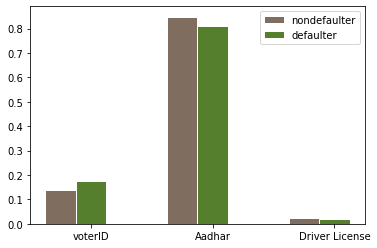

In [67]:
def_voterID = defaulter[defaulter['VoterID_flag']==1]['VoterID_flag'].count() / len(defaulter)
nondef_voterID = nondefaulter[nondefaulter['VoterID_flag']==1]['VoterID_flag'].count() / len(nondefaulter)

def_aadhar = defaulter[defaulter['Aadhar_flag']==1]['Aadhar_flag'].count() / len(defaulter)
nondef_aadhar = nondefaulter[nondefaulter['Aadhar_flag']==1]['Aadhar_flag'].count() / len(nondefaulter)

def_driving = defaulter[defaulter['Driving_flag']==1]['Driving_flag'].count() / len(defaulter)
nondef_driving = nondefaulter[nondefaulter['Driving_flag']==1]['Driving_flag'].count() / len(nondefaulter)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [nondef_voterID, nondef_aadhar, nondef_driving]
bars2 = [def_voterID, def_aadhar, def_driving]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 # Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='nondefaulter')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='defaulter')
 
# Add xticks on the middle of the group bars
plt.xlabel('', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['voterID', 'Aadhar', 'Driver License'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

## Final Model Metrics

In [203]:
# Save features, predictor variable, model type, hyperparameters and performance metrics
# as a dictionary.
ind_features = list(X.columns)
predictor = y.name
data = {'metric names': ['features_list1',  'features_list2', 'features_list3', 'features_list4', 'features_list5','predictor variable','model', 'hyperparameters', 'performance metrics'],
                'metric values': [ind_features[0:11], ind_features[11:19], ind_features[19:26], ind_features[26:32], ind_features[32:41],predictor, 'GradientBoostingClassifer', ['learning_rate: 0.25', 'n_estimators: 150'], ['confusion matrix', 'f-1 score', 'gridsearchCV','train vs test']]}

In [204]:
# Obtain a dataframe: model_metrics
model_metrics  = pd.DataFrame(data = data)

In [180]:
# Save the dataframe as a csv file.
model_metrics.to_csv('model_metrics.csv')